# Classifying pitch accent from spectrograms with XResNet

In [1]:
import fastaudio
from fastaudio.core.all import *
from fastai.vision.all import *

/home/studio-lab-user/.conda/envs/default/lib/python3.9/site-packages/torchaudio/backend/utils.py:46: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  warnings.warn(


In [145]:
%config InlineBackend.figure_format = 'retina'

In [2]:
Path()

Path('.')

In [3]:
# here = untar_data("https://gitlab.com/mizoru/datasets/-/raw/main/cleanAudio.tar")

In [4]:
# tarfile.open("/home/studio-lab-user/.fastai/archive/cleanAudio.tar").extractall()

In [84]:
path = Path()/'cleanAudio'

In [6]:
# path.ls(file_exts='.csv')

(#1) [Path('labels_no_duplicates.csv')]

In [7]:
# shutil.move(path/'labels_no_duplicates.csv', Path())

In [8]:
data = pd.read_csv('labels_no_duplicates.csv', low_memory=False)

In [9]:
data

,Unnamed: 0,path,pattern,kana,syl,drop
0,0,ある.yomi000142BB_0596.mp3,頭高,アル,2,1
1,2,思う.yomi0006C617_043A.mp3,中高,オモウ,3,2
2,3,など.yomi000240B7_0028.mp3,頭高,ナド,2,1
3,4,私.yomi00092F63_0072.mp3,平板,ワタくシ,4,0
4,5,見る.yomi000A41BD_001E.mp3,頭高,ミル,2,1
...,...,...,...,...,...,...
66489,74183,捨てがな_捨て仮名.yomi00072538_06BE.mp3,平板,すテカ゚ナ,5,0
66490,74185,くも膜下出血_蜘蛛膜下出血.yomi0001AAD1_0622.mp3,中高,クモマッカしュッケツ,10,6
66491,74187,捜す.yomi00072507_0088.mp3,平板,サカ゚ス,4,0
66492,74188,捜し物.yomi000724FD_0424.mp3,平板,サカ゚シモノ,6,0


In [239]:
cnfg = AudioConfig.Voice()

In [128]:
at = AudioTensor.create(path/'捨てがな_捨て仮名.yomi00072538_06BE.mp3')

In [240]:
aud2spec = AudioToSpec.from_cfg(cnfg)

TypeError: __init__() got an unexpected keyword argument 'linthreshy'

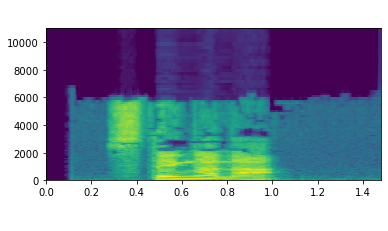

In [130]:
aud2spec(at).show()

In [ ]:
at.show()

In [13]:
crop2s = ResizeSignal(2000)

In [14]:
data = data.iloc[:,1:].set_index('path')

In [15]:
data

,pattern,kana,syl,drop
path,,,,
ある.yomi000142BB_0596.mp3,頭高,アル,2,1
思う.yomi0006C617_043A.mp3,中高,オモウ,3,2
など.yomi000240B7_0028.mp3,頭高,ナド,2,1
私.yomi00092F63_0072.mp3,平板,ワタくシ,4,0
見る.yomi000A41BD_001E.mp3,頭高,ミル,2,1
...,...,...,...,...
捨てがな_捨て仮名.yomi00072538_06BE.mp3,平板,すテカ゚ナ,5,0
くも膜下出血_蜘蛛膜下出血.yomi0001AAD1_0622.mp3,中高,クモマッカしュッケツ,10,6
捜す.yomi00072507_0088.mp3,平板,サカ゚ス,4,0


In [16]:
data.loc['ある.yomi000142BB_0596.mp3'][0]

'頭高'

In [17]:
def get_label(fname):
    return data.loc[fname][0]

In [18]:
dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  get_items=get_audio_files,
                   item_tfms=[crop2s, aud2spec],
                   get_y=using_attr(get_label, 'name'),
                   splitter=RandomSubsetSplitter(0.1, 0.02)
                  )

In [19]:
dls = dblock.dataloaders(path, bs=32, shuffle=True)

In [ ]:
len(dls.get_idxs())

In [ ]:
dls.one_batch()[0].shape

In [62]:
learn = Learner(dls, xresnet50(pretrained=True), metrics=[accuracy, F1Score(average='weighted')])

In [60]:
learn.loss_func

FlattenedLoss of CrossEntropyLoss()

In [63]:
learn = learn.to_fp16()

In [56]:
learn.model[0][0].in_channels
def alter_learner(learn):
    layer = learn.model[0][0]
    layer.in_channels = 1
    layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
    learn.model[0][0] = layer

In [64]:
alter_learner(learn)

In [65]:
learn.fine_tune(5, 3e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.424598,4.219926,0.439428,0.277089,00:34


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.205065,0.845803,0.760722,0.740047,00:33
1,0.203014,0.758320,0.784048,0.767731,00:33
2,0.143726,0.127169,0.960873,0.956737,00:33
3,0.111206,0.120738,0.963130,0.956488,00:34
4,0.076544,0.093413,0.968397,0.964488,00:34


SuggestedLRs(lr_min=6.309573450380412e-08, lr_steep=9.12010818865383e-07)

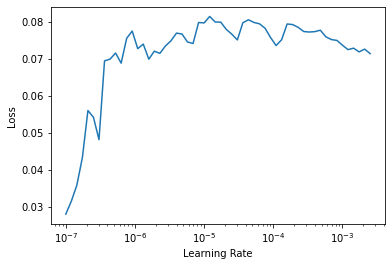

In [66]:
learn.lr_find()

In [68]:
learn.fit(3, slice(3e-7, 3e-6), wd=0.05)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.078476,0.092806,0.966892,0.962685,00:33
1,0.080976,0.093654,0.967645,0.963156,00:33
2,0.083820,0.091037,0.968397,0.964490,00:33


## Balanced Dataset

In [91]:
import random
random.seed(42)
nakadaka = random.sample(data[data.pattern == '中高'].index.values.tolist(), 2400)
atamadaka = random.sample(data[data.pattern == '頭高'].index.values.tolist(), 2400)
heiban = random.sample(data[data.pattern == '平板'].index.values.tolist(), 2400)

In [92]:
ds = [(i, 'nakadaka') for i in nakadaka] + [(i, 'atamadaka') for i in atamadaka] + [(i, 'heiban') for i in heiban]
df = pd.DataFrame(ds)

In [93]:
df[0] = path / df[0]

In [94]:
def get_x(df):
  return df[0]
def get_y(df):
  return df[1]

In [95]:
dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  get_x=get_x,
                   item_tfms=[crop2s, aud2spec],
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2)
                  )

In [96]:
dls2 = dblock.dataloaders(df)

In [113]:
learn2 = Learner(dls2, xresnet50(pretrained=True), CrossEntropyLossFlat(),
                 metrics=[accuracy, F1Score(average='weighted')], wd=0.05).to_fp16()

In [114]:
alter_learner(learn2)

SuggestedLRs(lr_min=0.07585775852203369, lr_steep=0.015848932787775993)

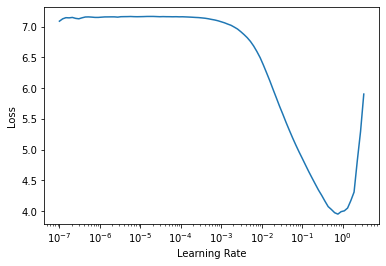

In [115]:
learn2.lr_find()

In [116]:
learn2.fine_tune(7, 9e-3)

epoch,train_loss,valid_loss,accuracy,f1_score,time
0,1.734659,0.703426,0.713889,0.700657,00:26


epoch,train_loss,valid_loss,accuracy,f1_score,time
0,0.363018,0.286336,0.909028,0.908712,00:26
1,0.229606,0.172058,0.947917,0.948306,00:26
2,0.133098,0.254065,0.905556,0.902066,00:26
3,0.088526,0.105291,0.961111,0.961012,00:26
4,0.060891,0.073923,0.967361,0.967326,00:27
5,0.043505,0.065347,0.975694,0.975679,00:27
6,0.033957,0.058501,0.975694,0.975704,00:27


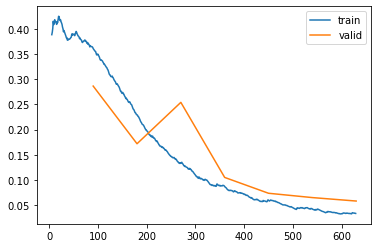

In [119]:
learn2.recorder.plot_loss()

## Data Augmentation

In [150]:
from fastaudio.augment.all import *

In [120]:
DBMelSpec = SpectrogramTransformer()

In [241]:
aud2spec.settings

{'mel': 'True',
 'to_db': 'False',
 'sample_rate': 16000,
 'n_fft': 1024,
 'win_length': 1024,
 'hop_length': 128,
 'f_min': 50.0,
 'f_max': 8000.0,
 'pad': 0,
 'n_mels': 128,
 'window_fn': <function _VariableFunctionsClass.hann_window>,
 'power': 2.0,
 'normalized': False,
 'wkwargs': None,
 'center': True,
 'pad_mode': 'reflect',
 'onesided': True,
 'norm': None,
 'stype': 'power',
 'top_db': None}

In [230]:
# aud2spec = DBMelSpec(top_db=100,f_max=2000)

TypeError: __init__() got an unexpected keyword argument 'linthreshy'

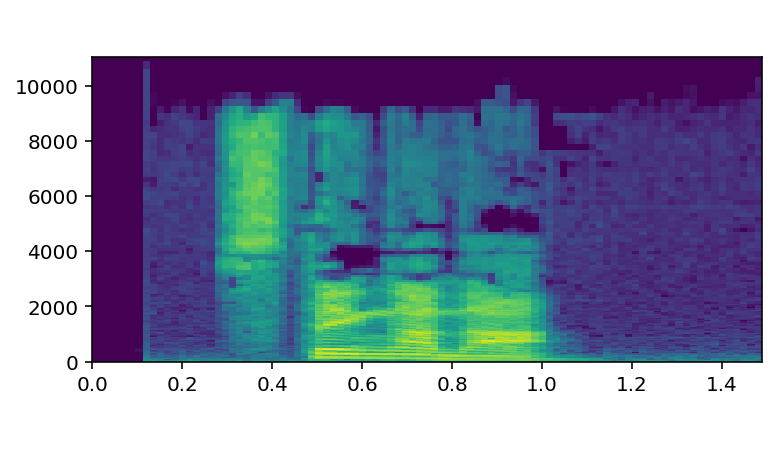

In [151]:
aud2spec(at).show()

In [250]:
item_tfms=[RemoveSilence(), ResizeSignal(2000), aud2spec, MaskTime(1,size=4), MaskFreq(1,size=3)]

<AxesSubplot:>

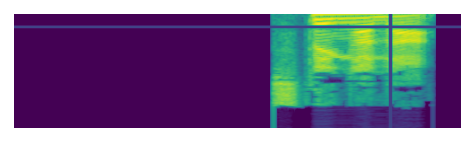

In [251]:
show_image(Pipeline(item_tfms)(at))

<AxesSubplot:>

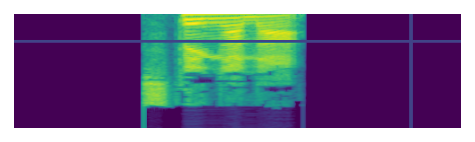

In [252]:
show_image(Pipeline(item_tfms)(at))

In [253]:
dblock = DataBlock(blocks=[AudioBlock, CategoryBlock],
                  get_x=get_x,
                   item_tfms=item_tfms,
                   get_y=get_y,
                   splitter=RandomSplitter(valid_pct=0.2)
                  )

In [254]:
dls3 = dblock.dataloaders(df, )

In [255]:
learn3 = Learner(dls3, xresnet50(True), CrossEntropyLossFlat(),
                 wd=0.05, metrics=[accuracy, F1Score(average='weighted')]).to_fp16()

In [256]:
alter_learner(learn3)

In [ ]:
learn3.lr_find()

In [ ]:
learn3.fine_tune(10, 7e-3)